In [68]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import math
import matplotlib
import seaborn as sns


# read data from csv file
df = pd.read_csv('autos.csv', sep=',', header=0, encoding='cp1252')
df = df.head(1000)

# Check data information
df.info()

# Check data statistics
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
dateCrawled            1000 non-null object
name                   1000 non-null object
seller                 1000 non-null object
offerType              1000 non-null object
price                  1000 non-null int64
abtest                 1000 non-null object
vehicleType            882 non-null object
yearOfRegistration     1000 non-null int64
gearbox                938 non-null object
powerPS                1000 non-null int64
model                  949 non-null object
kilometer              1000 non-null int64
monthOfRegistration    1000 non-null int64
fuelType               908 non-null object
brand                  1000 non-null object
notRepairedDamage      806 non-null object
dateCreated            1000 non-null object
nrOfPictures           1000 non-null int64
postalCode             1000 non-null int64
lastSeen               1000 non-null object
dtypes: int64(7), object(1

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000
mean,5755.082000,2002.76300,111.198000,125015.000000,5.951000,0.0,50072.922000
std,8648.759095,29.35552,71.143434,40629.737269,3.774234,0.0,25873.721049
min,0.000000,1111.00000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1200.000000,1999.00000,71.000000,100000.000000,3.000000,0.0,29656.250000
50%,2994.000000,2004.00000,105.000000,150000.000000,6.000000,0.0,49587.500000
75%,7500.000000,2009.00000,150.000000,150000.000000,9.000000,0.0,69683.500000
max,139997.000000,2018.00000,510.000000,150000.000000,12.000000,0.0,99974.000000


['vehicleType', 'gearbox', 'model', 'fuelType', 'brand', 'notRepairedDamage']


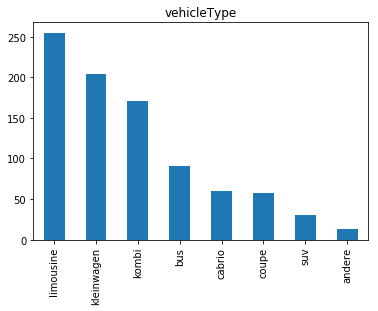

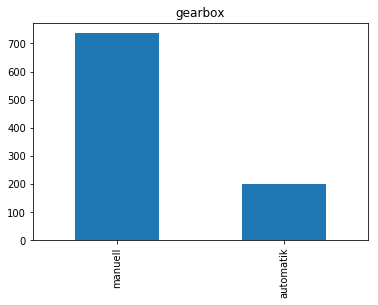

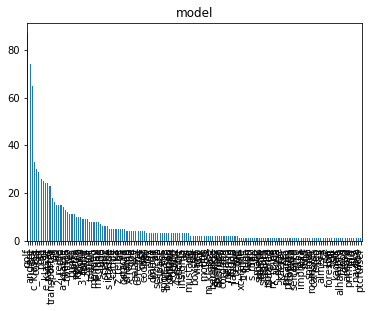

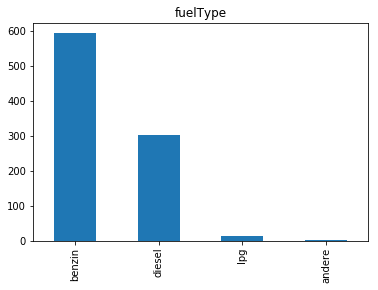

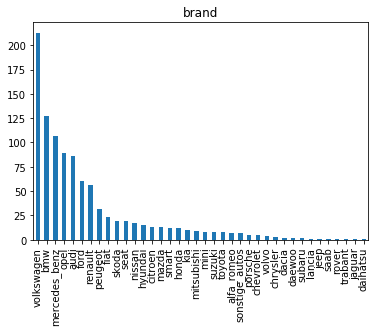

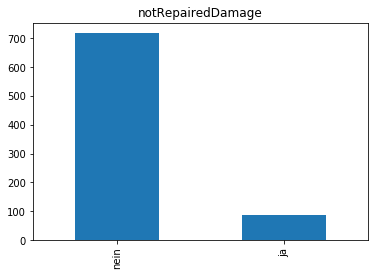

In [69]:

# Restructuring -> Vertical Decomposition
# drop low impact data on price
df.drop(['seller', 'offerType', 'abtest', 'dateCrawled', 'nrOfPictures', 'lastSeen', 'postalCode', 'dateCreated'], axis='columns', inplace=True)


# Remove unusable data(redundant data)
df = df.drop_duplicates(['name','price','vehicleType','yearOfRegistration'
                         ,'gearbox','powerPS','model','kilometer','monthOfRegistration','fuelType'
                         ,'notRepairedDamage'])



category_feature = [col for col in df.columns if df[col].dtypes == 'object' and col != 'name']
print(category_feature)

for col in category_feature:
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.show()
    



['price', 'yearOfRegistration', 'powerPS', 'kilometer', 'monthOfRegistration']


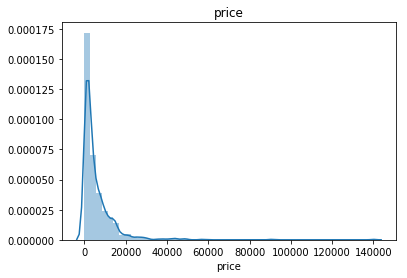

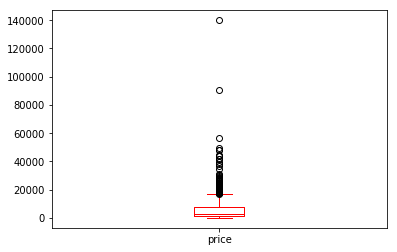

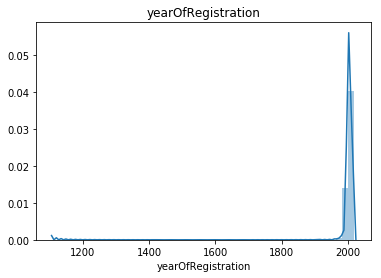

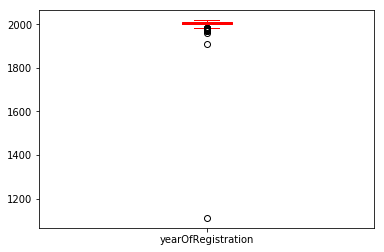

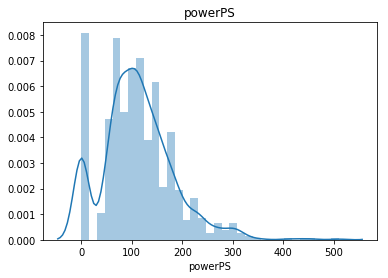

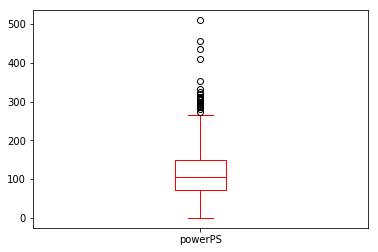

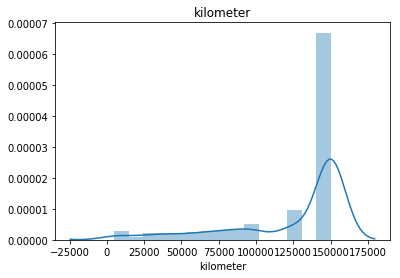

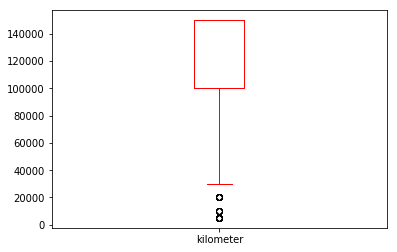

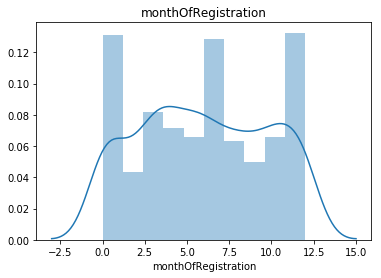

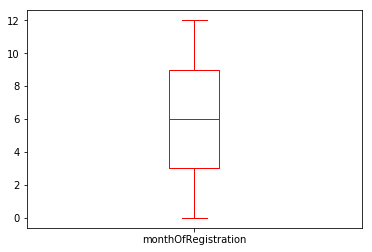

In [70]:

numerical_feature = [col for col in df.columns if df[col].dtypes == 'int64']
print(numerical_feature)

for col in numerical_feature:
    sns.distplot(df.loc[df[col].notnull(), col])
    plt.title(col)
    plt.show()
    df[col].plot(kind='box', color='red')
    plt.show()

    
# # remove the outlier of numerical data
# for col in numerical_feature:
#     Q1 = data[col].quantile(0.25)
#     Q3 = data[col].quantile(0.75)
#     IQR = Q3 - Q1
#     print(col, IQR)
#     data =  data[(data[col] >= (Q1 - 1.5 * IQR))
#             & (data[col] <= (Q3 + 1.5 * IQR))]
#     print(data)
#    print((df[col] < (Q1 - 1.5 * IQR)) or (df[col] >(Q3 +1.5 * IQR)))

# Remove the outliers and wrong data
df = df[
        (df.yearOfRegistration <= 2019)
      & (df.yearOfRegistration >= 1970)
      & (df.price >= 100)
      & (df.price <= 80000)
      & (df.powerPS >= 10)
      & (df.powerPS <= 400)]

 



In [71]:

# Missing data
df.isnull().sum()

# 'model' of car
df = df[df['model'].notnull()]

# Replace null with others
# Replace with the most value according to model type.
# value_counts() --> 맨 위 최빈값.
# 모델 종류를 다 돌아가면서 VehicleType, fuleType, gearbox 중 missing 값인 경우, 해당 모델의 최빈값을 가져와 채움.

for i in range(len(df['model'].unique())) :
    df["vehicleType"].fillna(df.vehicleType[df["model"]==df['model'].unique()[i]].value_counts().index[0], inplace=True)
    df["fuelType"].fillna(df.fuelType[df["model"]==df['model'].unique()[i]].value_counts().index[0], inplace=True)
    df["gearbox"].fillna(df.gearbox[df["model"]==df['model'].unique()[i]].value_counts().index[0], inplace=True)

# null in 'notRepairedDamage' is one of the deciding factors for price prediction.
# -> replace null with 'not-declared'
df["notRepairedDamage"].fillna(value='not-declared', inplace=True)

# Check the misting data is processed.
print(df.isnull().sum())
print(len(df))



name                   0
price                  0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dtype: int64
823


In [72]:
# columns that value is string
les = {}


# label encoder
# encode string columns to 0~k-1 labels
for l in category_feature:
    les[l] = preprocessing.LabelEncoder()
    les[l].fit(df[l].astype(str))
    tr = les[l].transform(df[l].astype(str))
    df.loc[:, l + '_encode'] = pd.Series(tr, index=df.index)

# extract only necessary columns to analysis
df = df[ ['price'
                ,'yearOfRegistration'
                ,'powerPS'
                ,'kilometer'
                ,'monthOfRegistration']
                + [x+"_encode" for x in category_feature]]


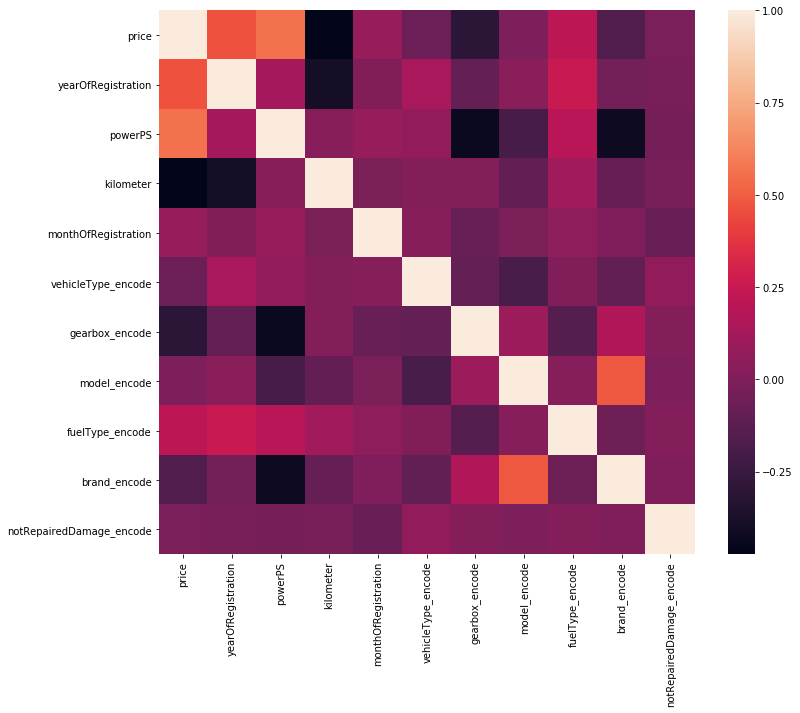

In [73]:

# correlation
# calculate the correlation matrix
corr = df.corr()
# adjust matrix size to (12, 10)
plt.subplots( figsize =( 12 , 10 ) )
# plot the correlation heatmap
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [74]:

# Split X and Y
# Y --> price column
# X --> data without price column
Y = df['price']
X = df.drop(['price'], axis=1, inplace=False)

# standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
#X_scale = pd.DataFrame(X_scale, columns = X.columns)
print(X)
print(Y)


     yearOfRegistration   powerPS  kilometer  monthOfRegistration  \
0              0.002758  0.676443  -0.026517             0.483733   
1             -0.451225 -0.888405   0.622980            -0.066906   
2              0.608069 -0.995100  -0.935812             0.208413   
3             -1.359192 -0.408281   0.622980             1.034372   
4              0.002758 -0.283805   0.622980             0.483733   
5              1.516036  0.000713  -2.494605             0.483733   
6             -0.905208 -0.426064   0.622980            -1.718824   
7              0.002758 -0.354934   0.622980             1.585011   
8              0.154086  0.267449   0.622980             1.585011   
9             -1.359192 -0.177111   0.622980             1.309691   
10             0.002758  0.107407   0.622980            -1.168185   
11             1.062052  1.156567  -1.455410            -0.892865   
12             1.818691 -1.155141   0.622980            -1.718824   
13             0.002758 -0.888405 

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
